# Model Consolidation

### Libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt   
%matplotlib inline
from music21 import *
from IPython.display import Audio
from intervaltree import Interval,IntervalTree
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import tensorflow as tf

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore')




In [4]:
! pip install music21

  Created wheel for music21: filename=music21-6.7.1-py3-none-any.whl size=21941699 sha256=f449a97339428c67814c82b1e13074a3d3097213cb07da51e9c235e9ec8a1cb7
  Stored in directory: c:\users\david.ristau\appdata\local\pip\cache\wheels\54\ee\05\49c0a0f02167de02da2d44d86afbc6e399073f2244d5a9f6b8
Successfully built music21


### Import csv features which were extracted from earlier Data PreProcessing notebook

In [6]:
#Get metadata
metadata=pd.read_csv('../data/musicnet_metadata.csv')

#Get consolidated saved csvs of WAV Spectral features only
train_wav = pd.read_csv('../data/df_train_wav_consolidated.csv',index_col=0)
test_wav = pd.read_csv('../data/df_test_wav_finc.csv',index_col=0)

#Get midi features only
midi_features = pd.read_csv('../data/midi_features.csv',index_col=0)



### Import Wav Data for Spectral Features only

In [7]:
#Create X and y for Wav Data only

#Make a copy of the metadata
meta_data_copy = metadata.copy(deep=True)
meta_data_copy.reset_index(inplace=True)

#Rename column name
meta_data_copy = meta_data_copy.rename(columns = {'id':'filename'})

#Merge Metadata and Wav Data Only
merged_train_data_w = pd.merge(train_wav , meta_data_copy , on="filename")
merged_train_data_w = merged_train_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

merged_test_data_w = pd.merge(test_wav , meta_data_copy , on="filename")
merged_test_data_w = merged_test_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

#Checked that unique ensembles in test are a subset of train
#Get list of unique ensembles
ens_list = merged_train_data_w['ensemble'].unique()

#Map list of unique ensemble names to integer
mapping = {item:i for i, item in enumerate(ens_list)}
merged_train_data_w["ensemble"] = merged_train_data_w["ensemble"].apply(lambda x: mapping[x])
merged_test_data_w["ensemble"] = merged_test_data_w["ensemble"].apply(lambda x: mapping[x])

#This is the original train test split given in kaggle. 
#The code is selecting only the ensemble for the y and letting the rest of the features be in X

X_original_train = merged_train_data_w.iloc[:,np.r_[:167,168]]
X_original_test = merged_test_data_w.iloc[:,np.r_[:167,168]]

y_original_train = merged_train_data_w.iloc[:,167:168]
y_original_test = merged_test_data_w.iloc[:,167:168]

#Concatenate the training and test data
x_frames = [X_original_train,X_original_test]
X_wav = pd.concat(x_frames , ignore_index=True)

y_frames = [y_original_train,y_original_test]
y_wav = pd.concat(y_frames , ignore_index=True)

#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet_wav_only = y_wav[ y_wav['ensemble'] == 3 ].index
y_wav.drop(index_violaquintet_wav_only , inplace=True)
X_wav.drop(index_violaquintet_wav_only , inplace=True)

#This is the train test split for Spectral Wav Data only
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

### Print list of ensembles for reference

In [8]:
#print ensemble list
ens_list

array(['Piano Quintet', 'Solo Piano', 'Piano Trio', 'Viola Quintet',
       'String Quartet', 'Clarinet Quintet',
       'Pairs Clarinet-Horn-Bassoon', 'Wind Quintet', 'Accompanied Cello',
       'Accompanied Clarinet', 'Wind and Strings Octet', 'String Sextet',
       'Piano Quartet', 'Horn Piano Trio', 'Solo Violin', 'Solo Flute',
       'Solo Cello', 'Violin and Harpsichord',
       'Clarinet-Cello-Piano Trio', 'Accompanied Violin', 'Wind Octet'],
      dtype=object)

### Import MIDI Features for Engineered Features from Granular Data

In [9]:
#Create X and y for Granular MIDI Data Attributes only

#Make a copy of the midi features
midi_features_copy = midi_features.copy(deep=True)
midi_features_copy.reset_index(inplace=True)

#Rename column name in both the copy and the original
midi_features_copy = midi_features_copy.rename(columns = {'file_name':'filename'})
midi_features = midi_features.rename(columns = {'file_name':'filename'})


#Merge Metadata and MIDI Data only

#For original midi
merged_midi_data = pd.merge(midi_features , meta_data_copy , on="filename")
merged_midi_data = merged_midi_data.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

#For midi copy
merged_midi_data_copy = pd.merge(midi_features_copy , meta_data_copy , on="filename")
merged_midi_data_copy = merged_midi_data_copy.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index_x"], axis=1)

#Map list of unique ensemble names to integer

#For original midi
merged_midi_data["ensemble"] = merged_midi_data["ensemble"].apply(lambda x: mapping[x])

#For midi copy
merged_midi_data_copy["ensemble"] = merged_midi_data_copy["ensemble"].apply(lambda x: mapping[x])

#To select data for train and test for midi based on the same splits done for wav based on multiple conditions you can use &:
#Removes file name as a feature and also removes viola quintet
midi_train = merged_midi_data.loc[merged_midi_data['filename'].isin(filenames_in_train)]
X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

midi_test = merged_midi_data.loc[merged_midi_data['filename'].isin(filenames_in_test)]
X_test_m = midi_test.iloc[:,np.r_[1:10,11]]
y_test_m = midi_test.iloc[:,np.r_[10]]

### Create Merged Dataset comprising Engineered Features from MIDI Data and Spectral Features from Wav Data

In [10]:
# Create Dataset with MIDI and WAV Spectral Data

#Drop duplicate columns
merged_midi_data_copy.drop(['seconds','index_y'],axis=1,inplace=True) 

#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet_midi_only = merged_midi_data_copy[ merged_midi_data_copy['ensemble'] == 3 ].index
merged_midi_data_copy.drop(index_violaquintet_midi_only , inplace=True)

#Merge Midi and Wav Data 
merged_data_c = pd.merge(X_wav, merged_midi_data_copy , on="filename")

#To select data for train and test for midi based on the same splits done for wav based on multiple conditions you can use &:
#Removes file name as a feature and also removes viola quintet
comb_train = merged_data_c.loc[merged_data_c['filename'].isin(filenames_in_train)]
X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]

comb_test = merged_data_c.loc[merged_data_c['filename'].isin(filenames_in_test)]
X_test_c = comb_test.iloc[:,np.r_[0,2:177]]
y_test_c = comb_test.iloc[:,np.r_[177]]

In [11]:
print('Shape of Wav Data :')
print( X_train_w.shape, y_train_w.shape , X_test_w.shape , y_test_w.shape)

Shape of Wav Data :
(263, 167) (263, 1) (66, 167) (66, 1)


In [12]:
print('Shape of MIDI Data :')
print( X_train_m.shape, y_train_m.shape , X_test_m.shape , y_test_m.shape)

Shape of MIDI Data :
(263, 10) (263, 1) (66, 10) (66, 1)


In [13]:
print('Shape of Combined Wav and MIDI Data :')
print( X_train_c.shape, y_train_c.shape , X_test_c.shape , y_test_c.shape)

Shape of Combined Wav and MIDI Data :
(263, 176) (263, 1) (66, 176) (66, 1)


# Models

## 1. Logistic Regression

### 1.1 Spectral (WAV) Data Only

#### 1.1.1 Baseline model

In [14]:
#Create Baseline Logistic Model
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_w), np.array(y_train_w))

#cross validation with 5 fold on training data
scores = cross_val_score(estimator = lr, X=X_train_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Linear regression
CV Scores:  [0.88679245 0.88679245 0.86792453 0.90384615 0.94230769]
CV Average and standard deviation:  0.8975326560232221 +/- 0.02510780470472868


#### 1.1.2 PCA components

[0.8496704647266673, 0.9432045674275258, 0.9657437073371652, 0.974015402612845, 0.9808146810370991, 0.9842105572644044, 0.9869234364301777, 0.9895492330696729]


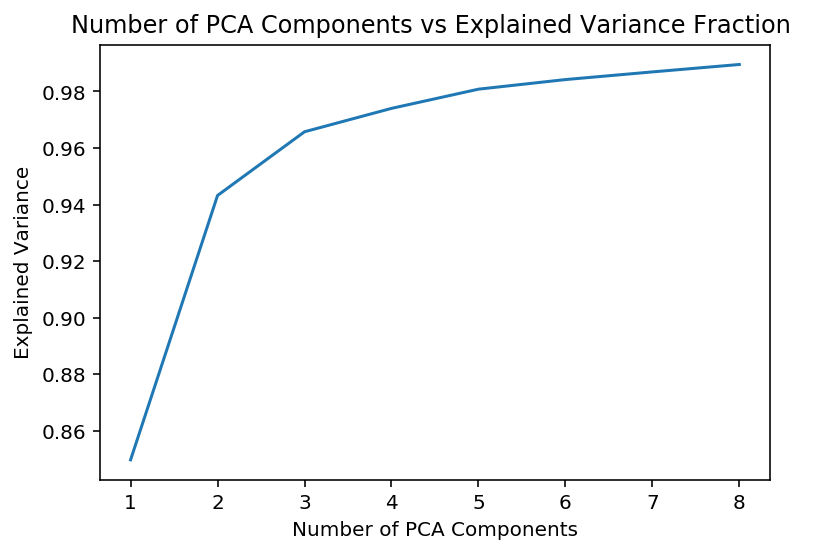

Linear regression
CV Scores:  [0.67924528 0.69811321 0.66037736 0.71153846 0.69230769]
CV Average and standard deviation:  0.6883164005805515 +/- 0.017401420621599144


In [15]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_w.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_w)
X_train_pca = pca.transform(X_train_w)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_w)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))
      

### 1.2 MIDI Data Only 

#### 1.2.1 Baseline model

In [17]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_m), np.array(y_train_m))
scores = cross_val_score(estimator = lr, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.69811321 0.75471698 0.67924528 0.65384615 0.76923077]
CV Average and standard deviation:  0.7110304789550072 +/- 0.044142917620219664


#### 1.2.2 PCA components

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

[0.847246925156634, 0.9999994828649594, 0.9999999950423858, 0.9999999979326264, 0.9999999995373896, 0.9999999998110075, 0.9999999999006715, 0.9999999999631857]


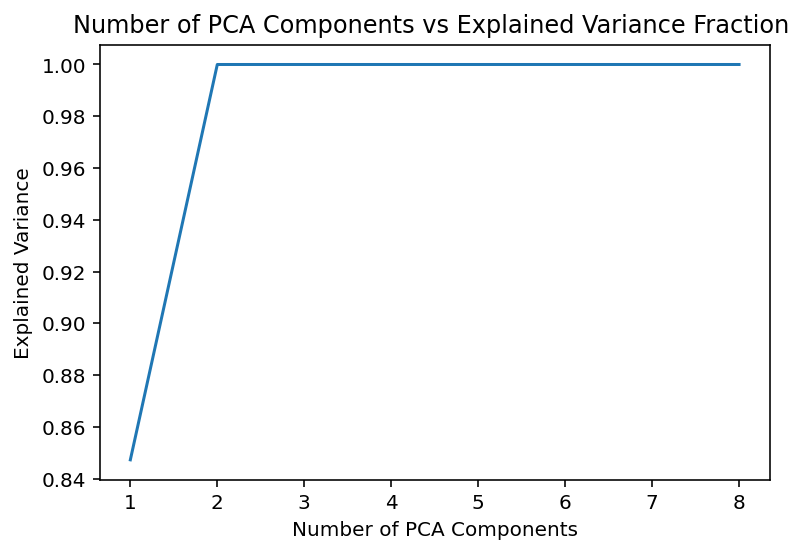

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.47169811 0.47169811 0.16981132 0.48076923 0.48076923]
CV Average and standard deviation:  0.4149492017416546 +/- 0.1226360559071233


In [28]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_m.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_m)
    train_pca = pca.transform(X_train_m)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_m)
X_train_pca = pca.transform(X_train_m)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_w)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))


### 1.3 Combined Data (WAV & MIDI) 

#### 1.3.1 Baseline model

In [18]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_c), np.array(y_train_c))
scores = cross_val_score(estimator = lr, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.81132075 0.86792453 0.90566038 0.82692308 0.90384615]
CV Average and standard deviation:  0.863134978229318 +/- 0.038690476180831046


#### 1.3.2 PCA components

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

[0.8472467564714535, 0.9999993006005323, 0.9999998191050802, 0.9999999250480672, 0.9999999510448121, 0.9999999628415001, 0.9999999703478009, 0.9999999753281146]


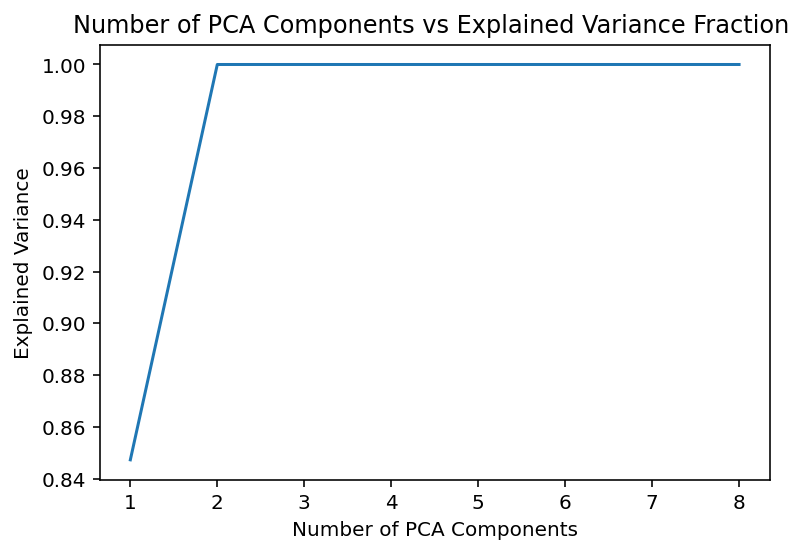

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.47169811 0.43396226 0.45283019 0.48076923 0.46153846]
CV Average and standard deviation:  0.4601596516690857 +/- 0.016123374972447535


In [30]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_c.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_c)
    train_pca = pca.transform(X_train_c)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_c)
X_train_pca = pca.transform(X_train_c)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_c)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))


---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [31]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


C:\Users\nojed\anaconda3\lib\site-packages\pandas\core\frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 2. Naive Bayes

### 2.1 Spectral (WAV) Data Only

#### 2.1.1 Baseline model

In [35]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
print('Naive Bayes')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Naive Bayes
CV Scores:  [0.69811321 0.71698113 0.71698113 0.67307692 0.61538462]
CV Average and standard deviation:  0.6841074020319303 +/- 0.0379526539589294


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

### 2.2 MIDI Data Only

#### 2.2.1 Baseline model

In [36]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
print('Naive Bayes')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Naive Bayes
CV Scores:  [0.58490566 0.32075472 0.69811321 0.59615385 0.75      ]
CV Average and standard deviation:  0.5899854862119013 +/- 0.14821964049306927


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

### 2.3 Combined Data (WAV & MIDI)

#### 2.3.1 Baseline model

In [37]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Naive Bayes')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Naive Bayes
CV Scores:  [0.71698113 0.75471698 0.73584906 0.75       0.69230769]
CV Average and standard deviation:  0.7299709724238026 +/- 0.02295795020311934


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


## 3. Decision Tree

### 3.1 Spectral (WAV) Data Only

#### 3.1.1 Baseline model

In [38]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
print('Decision Tree')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Decision Tree
CV Scores:  [0.71698113 0.75471698 0.67924528 0.78846154 0.71153846]
CV Average and standard deviation:  0.730188679245283 +/- 0.03772230972918628


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


### 3.2 MIDI Data Only

#### 3.2.1 Baseline model

In [39]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
print('Decision Tree')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Decision Tree
CV Scores:  [0.83018868 0.77358491 0.83018868 0.90384615 0.82692308]
CV Average and standard deviation:  0.8329462989840348 +/- 0.04147783160686735


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


### 3.3 Combined Data (WAV & MIDI)

#### 3.3.1 Baseline model

In [40]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Decision Tree')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Decision Tree
CV Scores:  [0.79245283 0.79245283 0.83018868 0.90384615 0.92307692]
CV Average and standard deviation:  0.8484034833091437 +/- 0.055213662402209


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


## 4. Random Forest

### 4.1 Spectral (WAV) Data Only

#### 4.1.1 Baseline model

<ipython-input-44-290332bb42d9>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_w, y_train_w)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estima

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only WAV data
CV Scores:  [0.8490566  0.81132075 0.73584906 0.86538462 0.86538462]
CV Average and standard deviation:  0.8253991291727141 +/- 0.0489382681428624


<AxesSubplot:>

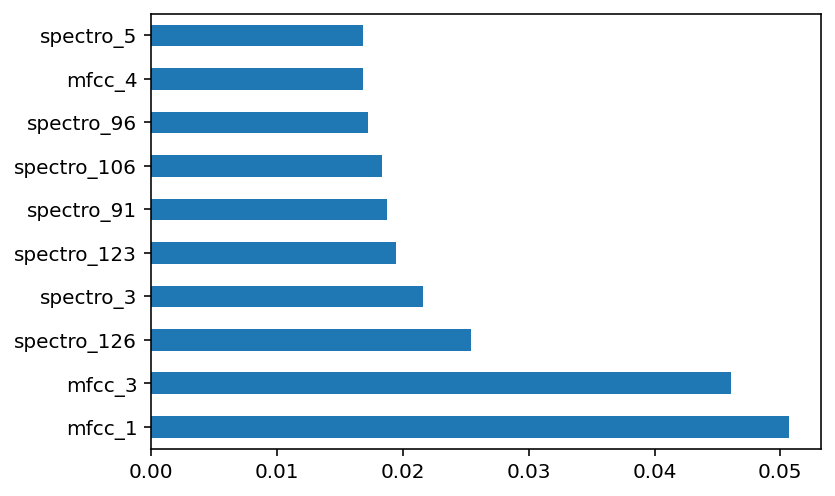

In [44]:
rf = RandomForestClassifier()
rf.fit(X_train_w, y_train_w)
scores = cross_val_score(estimator = rf, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
print('Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

feat_importances = pd.Series(rf.feature_importances_, index=X_train_w.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### 4.1.2 Sampling (SMOTE), no hyperparameter tuning

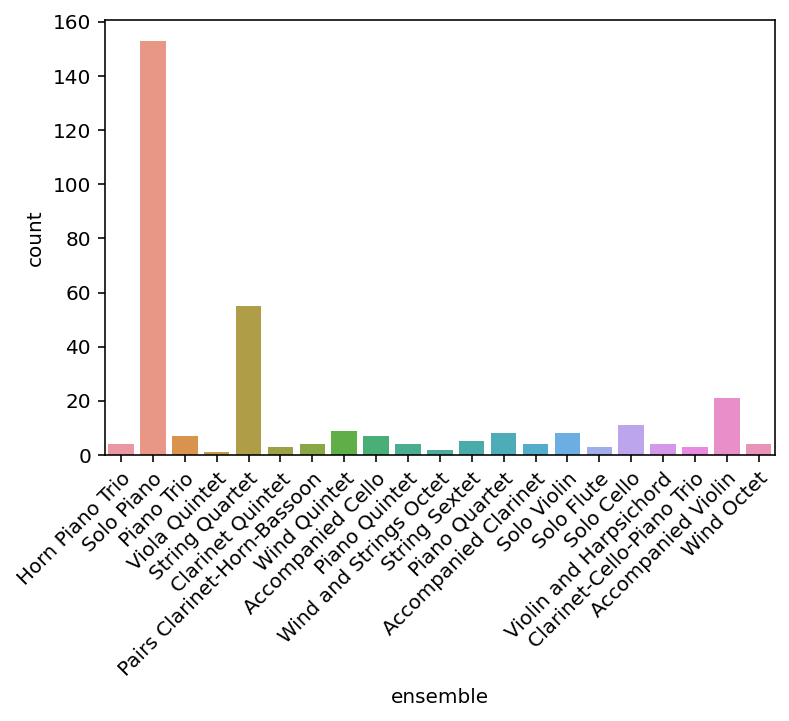

(231, 167) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6})
Resample dataset shape Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})


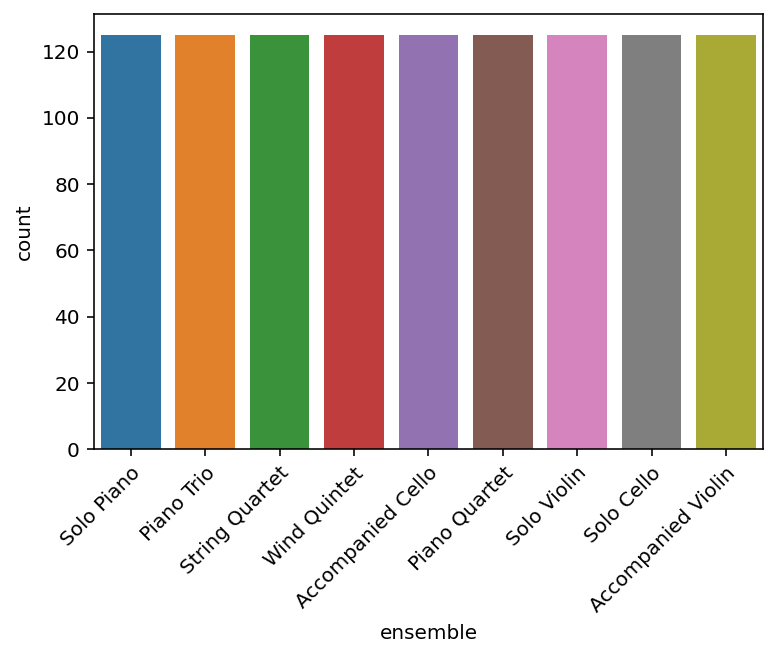

<ipython-input-48-dfb0bb9ca462>:62: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_SMOTE_w, y_SMOTE_w)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Random Forest: Sample with SMOTE, no hyperparameter tuning / Only WAV data
CV Scores:  [0.99555556 0.98666667 0.99555556 1.         1.        ]
CV Average and standard deviation:  0.9955555555555555 +/- 0.004868644955601467


<AxesSubplot:>

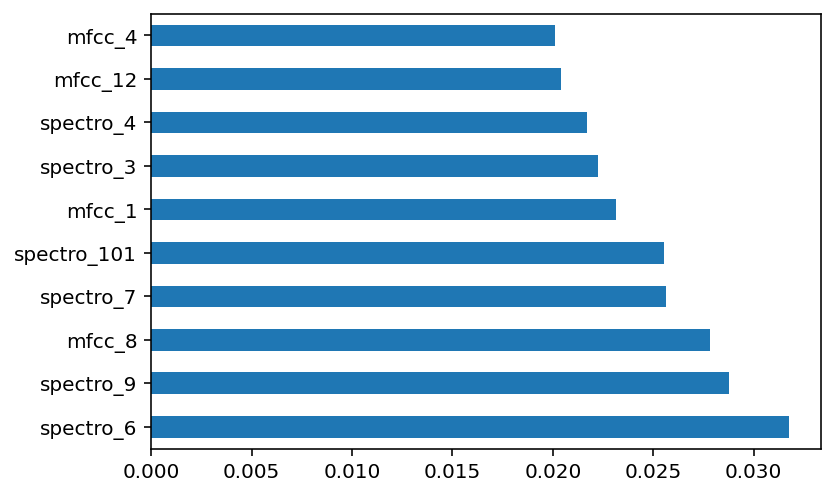

In [48]:
# Visualize the target variable
g = sns.countplot(merged_train_data_w['ensemble'])
g.set_xticklabels(['Horn Piano Trio',
'Solo Piano',
'Piano Trio',
'Viola Quintet',
'String Quartet',
'Clarinet Quintet',
'Pairs Clarinet-Horn-Bassoon',
'Wind Quintet',
'Accompanied Cello',
'Piano Quintet',
'Wind and Strings Octet',
'String Sextet',
'Piano Quartet',
'Accompanied Clarinet',
'Solo Violin',
'Solo Flute',
'Solo Cello',
'Violin and Harpsichord',
'Clarinet-Cello-Piano Trio',
'Accompanied Violin',
'Wind Octet'],rotation_mode='anchor',rotation=45, ha='right')
plt.show()

#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_w['ensemble'].value_counts()
X_train_w = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
print(X_train_w.shape, y_train_w.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.


# Fit and apply the transform
X_SMOTE_w, y_SMOTE_w = SMOTE(random_state=101).fit_resample(X_train_w, y_train_w)

print('Original dataset shape', Counter(y_train_w.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_w.values.ravel()))

# Visualize the target variable
g = sns.countplot(y_SMOTE_w['ensemble'])
g.set_xticklabels([
'Solo Piano', 
'Piano Trio',
'String Quartet',
'Wind Quintet',
'Accompanied Cello',
'Piano Quartet',
'Solo Violin',
'Solo Cello',
'Accompanied Violin'],rotation_mode='anchor',rotation=45, ha='right')
plt.show()

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_w, y_SMOTE_w)
scores = cross_val_score(estimator = rf, X=X_SMOTE_w, y=y_SMOTE_w, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, no hyperparameter tuning / Only WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2

feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_w.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### 4.1.3 Sampling (SMOTE), hyperparameter tuning

In [ ]:
rf = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 75, 100, 125, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 3, 4, 5, 6]
}
clf = GridSearchCV(rf , model_params, cv=3) # set up grid search meta-estimator
clf.fit(X_SMOTE_w, y_SMOTE_w)
scores = cross_val_score(estimator = clf, X=X_SMOTE_w, y=y_SMOTE_w, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, hyperparameter tuning / Only WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print(clf.best_params_)

feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_w.columns)
feat_importances.nlargest(10).plot(kind='barh')

# *The above was too complex to run (Team to try on cloud or delete)

### 4.2 MIDI Data Only

#### 4.2.1 Baseline model

<ipython-input-52-0906a5f5ca5c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_m, y_train_m)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only MIDI data
CV Scores:  [0.9787234  0.89130435 0.97826087 1.         0.95652174]
CV Average and standard deviation:  0.9609620721554115 +/- 0.03744486142663875


<AxesSubplot:>

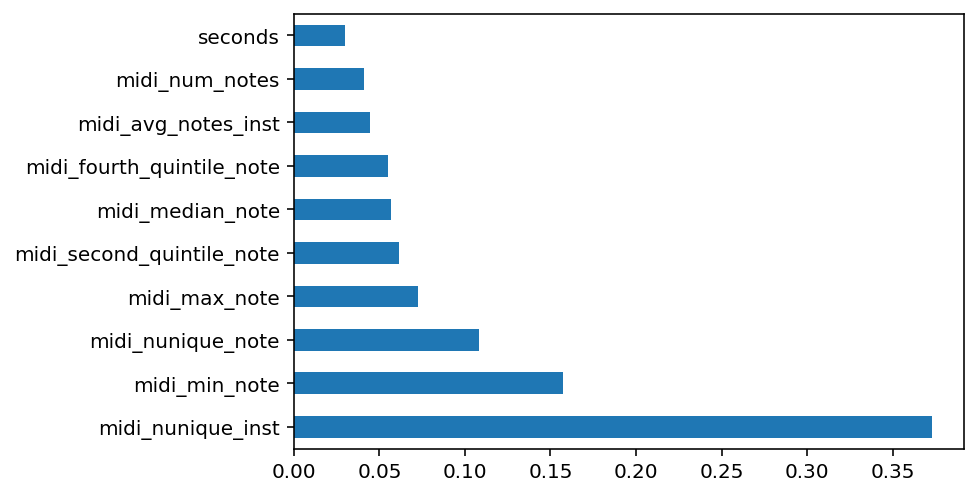

In [52]:
rf = RandomForestClassifier()
rf.fit(X_train_m, y_train_m)
scores = cross_val_score(estimator = rf, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
print('Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only MIDI data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

feat_importances = pd.Series(rf.feature_importances_, index=X_train_m.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### Observation : "midi_nunique instruments" seems to be the variable with the strongest explanatory power with 40% variance explained. We have concerns about evaluating performance using a feature set that includes this variable because in practice we typically would not have manually labelled data. 

#### 4.2.2 Sampling (SMOTE), no hyperparameter tuning

(231, 10) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 7: 7, 14: 7, 2: 6, 8: 6, 12: 6})
Resample dataset shape Counter({1: 125, 2: 125, 4: 125, 7: 125, 8: 125, 12: 125, 14: 125, 16: 125, 19: 125})


<ipython-input-53-5d6feb541bc7>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_SMOTE_m, y_SMOTE_m)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Random Forest: Sample with SMOTE, no hyperparameter tuning / Only MIDI data
CV Scores:  [0.99555556 0.99555556 0.99555556 0.99555556 0.98666667]
CV Average and standard deviation:  0.9937777777777776 +/- 0.003555555555555534


<AxesSubplot:>

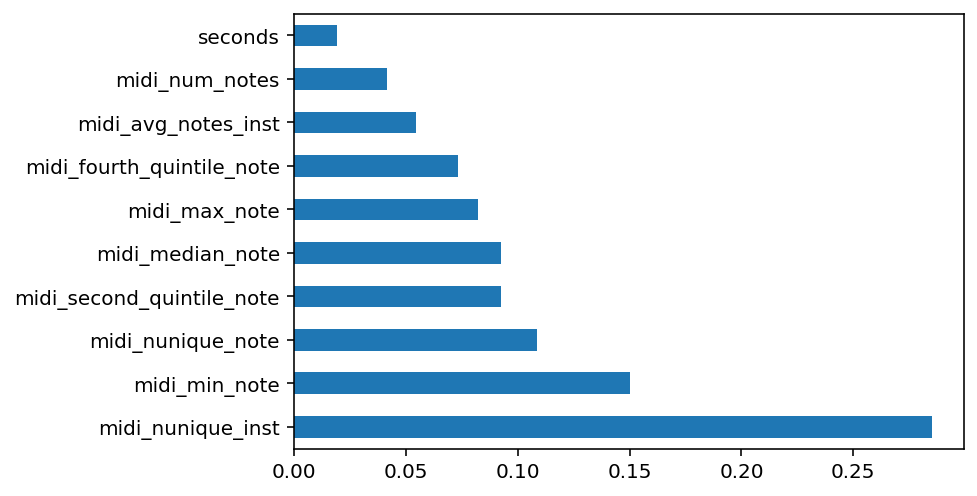

In [53]:
#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_m['ensemble'].value_counts()
X_train_m = X_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
y_train_m = y_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
print(X_train_m.shape, y_train_m.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.

# Fit and apply the transform
X_SMOTE_m, y_SMOTE_m = SMOTE(random_state=101).fit_resample(X_train_m, y_train_m)

print('Original dataset shape', Counter(y_train_m.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_m.values.ravel()))

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_m, y_SMOTE_m)
scores = cross_val_score(estimator = rf, X=X_SMOTE_m, y=y_SMOTE_m, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, no hyperparameter tuning / Only MIDI data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2
    
feat_importances = pd.Series(rf.feature_importances_, index=X_train_m.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### 4.2.3 Sampling (SMOTE), hyperparameter tuning

In [ ]:
rf = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 75, 100, 125, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 3, 4, 5, 6]
}


clf = GridSearchCV(rf , model_params, cv=3)
clf.fit(X_SMOTE_m, y_SMOTE_m) # set up grid search meta-estimator
clf

scores = cross_val_score(estimator = clf, X=X_SMOTE_m, y=y_SMOTE_m, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, hyperparameter tuning / Only MIDI data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print(clf.best_params_)


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

# * This needs to be run in cloud or deleted

### 4.3 Combined Data (WAV & MIDI)

#### 4.3.1 Baseline model

<ipython-input-54-b00466b1ec69>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_c, y_train_c)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estima

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Both MIDI & WAV data
CV Scores:  [0.77358491 0.88679245 0.83018868 0.82692308 0.94230769]
CV Average and standard deviation:  0.8519593613933237 +/- 0.05765327156504294


<AxesSubplot:>

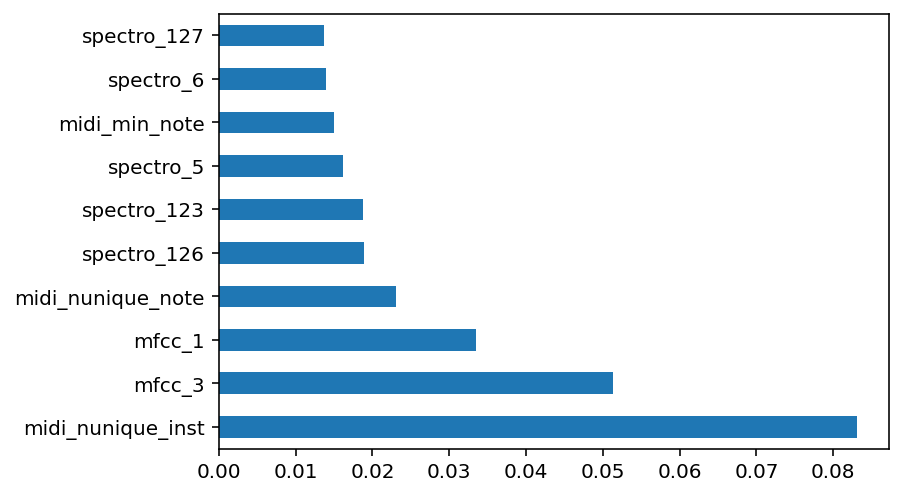

In [54]:
rf = RandomForestClassifier()
rf.fit(X_train_c, y_train_c)
scores = cross_val_score(estimator = rf, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Both MIDI & WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

feat_importances = pd.Series(rf.feature_importances_, index=X_train_c.columns)
feat_importances.nlargest(10).plot(kind='barh')

####  Observation : We can see here that the midi_nunique_instruments variable is still explaining far more variance in our dataset than any spectral feature. This indicates its strong predictive power in comparison.We have concerns about evaluating performance using a feature set that includes this variable because in practice we typically would not have manually labelled data. 

#### 4.3.2 Sampling (SMOTE), no hyperparameter tuning

(231, 176) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 7: 7, 14: 7, 2: 6, 8: 6, 12: 6})
Resample dataset shape Counter({1: 125, 2: 125, 4: 125, 7: 125, 8: 125, 12: 125, 16: 125, 14: 125, 19: 125})


<ipython-input-56-4379194a5284>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_SMOTE_c, y_SMOTE_c)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Random Forest: Sample with SMOTE, no hyperparameter tuning / Both MIDI & WAV data
CV Scores:  [0.98666667 1.         0.98666667 0.99111111 1.        ]
CV Average and standard deviation:  0.9928888888888888 +/- 0.006028737762778003


<AxesSubplot:>

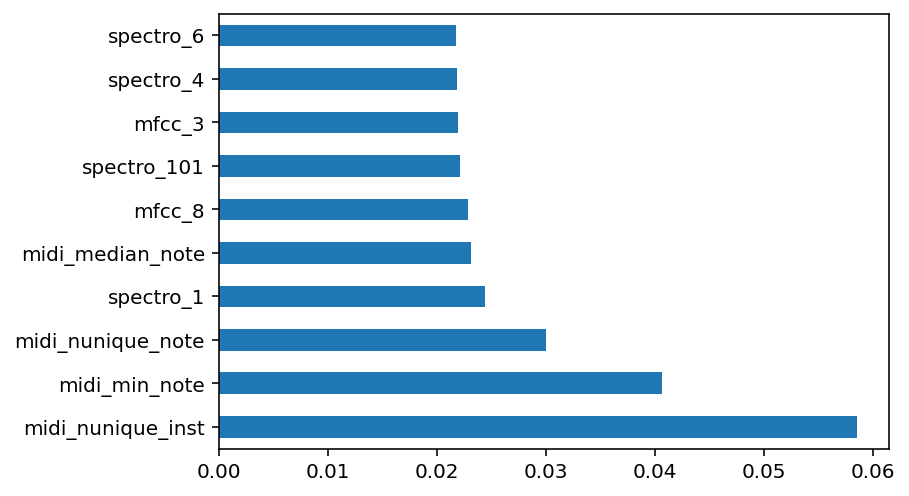

In [56]:
#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_c['ensemble'].value_counts()
X_train_c = X_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]
y_train_c = y_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]
print(X_train_c.shape, y_train_c.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.

X_SMOTE_c, y_SMOTE_c = SMOTE(random_state=101).fit_resample(X_train_c, y_train_c)

print('Original dataset shape', Counter(y_train_c.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_c.values.ravel()))


from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_c, y_SMOTE_c)
scores = cross_val_score(estimator = rf, X=X_SMOTE_c, y=y_SMOTE_c, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, no hyperparameter tuning / Both MIDI & WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2
    
feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_c.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### Observation : 

- Midi_min_note variable also has strong predictive power. Certain ensembles will have instruments that allow for lower notes to be played so the lowest note would probably be a good predictor of the ensemble. 

- Midi_nunique_note is important because ensembles composed of instruments with larger ranges will typically have a higher possibility of playing unique notes due to their unique access to notes that other ensembles might not have access to.

#### 4.3.3 Sampling (SMOTE), hyperparameter tuning

In [57]:
rf = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 75, 100, 125, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 3, 4, 5, 6]
}
clf = GridSearchCV(rf , model_params, cv=3) # set up grid search meta-estimator
clf.fit(X_SMOTE_c, y_SMOTE_c)
scores = cross_val_score(estimator = clf, X=X_SMOTE_c, y=y_SMOTE_c, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, hyperparameter tuning / Both MIDI & WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print(clf.best_params_)

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

KeyboardInterrupt: 

# * This needs to be run on cloud or deleted.

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [16]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


## 5. SVM

### 5.1 Spectral (WAV) Data Only

#### 5.1.1 Baseline model

In [17]:
#Create baseline SVM model with Spectral Data

svm = make_pipeline(SVC())
svm.fit(X_train_w, y_train_w.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5,n_jobs=1)
print('SVM Baseline with no hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

SVM Baseline with no hyperparameter tuning
CV Scores:  [0.52830189 0.60377358 0.56603774 0.61538462 0.59615385]
CV Average and standard deviation:  0.5819303338171263 +/- 0.03139175011674026


#### 5.1.2 Hyperparameter tuning

In [18]:
#Find best hyperparameters
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),                     
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid, cv=5)
  
# fitting the model for grid search
grid.fit(X_train_w, y_train_w.values.ravel())

print(grid.best_params_)


#Create Model with best hyperparameters

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(X_train_w, y_train_w.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

{'C': 0.004832930238571752, 'gamma': 0.001, 'kernel': 'linear'}
SVM with hyperparameter tuning
CV Scores:  [0.86792453 0.81132075 0.79245283 0.90384615 0.90384615]
CV Average and standard deviation:  0.8558780841799709 +/- 0.04637910452717963


#### 5.1.3 Hyperparameter tuning, PCA

    Number of PCA Components  Explained Fraction of Total Variance
0                          1                              0.849670
1                          2                              0.943205
2                          3                              0.965744
3                          4                              0.974015
4                          5                              0.980815
5                          6                              0.984211
6                          7                              0.986923
7                          8                              0.989549
8                          9                              0.991405
9                         10                              0.992736
10                        11                              0.993610
11                        12                              0.994300
12                        13                              0.994920
13                        14                              0.99

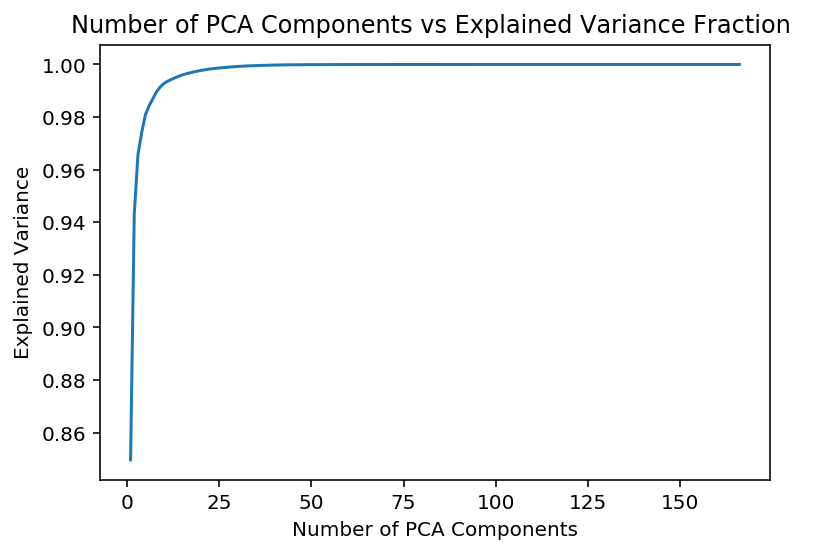

{'C': 0.03359818286283781, 'gamma': 0.001, 'kernel': 'linear'}
SVM with hyperparameter tuning and PCA
CV Scores:  [0.8490566  0.77358491 0.79245283 0.88461538 0.92307692]
CV Average and standard deviation:  0.8445573294629899 +/- 0.05575335257768051


In [19]:
# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 166 i.e. one less than 167
all_possible_k = np.arange(1,167)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    


plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_train_w)
train_pca_w = pca.transform(X_train_w)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w, y_train_w.values.ravel())

print(grid.best_params_)

#Create Model with best hyperparameters and PCA
svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w, y_train_w.values.ravel())


#Apply 5 fold cross validation scoring to make sure results are reliable
scores = cross_val_score(estimator = svm, X=train_pca_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning and PCA')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))



#### Observation : PCA does not reduce score but reduces number of features to just 15 principal components

 #### 5.1.4 Hyperparameter tuning, PCA, SMOTE

Before oversampling:  Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6, 6: 5, 11: 4, 20: 3, 13: 3, 0: 3, 9: 3, 17: 3, 10: 2, 5: 2, 15: 2, 18: 2})
(231, 167) (231, 1)
After oversampling:  Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})
    Number of PCA Components  Explained Fraction of Total Variance
0                          1                              0.800638
1                          2                              0.927088
2                          3                              0.967376
3                          4                              0.979137
4                          5                              0.984384
5                          6                              0.988673
6                          7                              0.991269
7                          8                              0.992420
8                          9                              0.993544
9                         10       

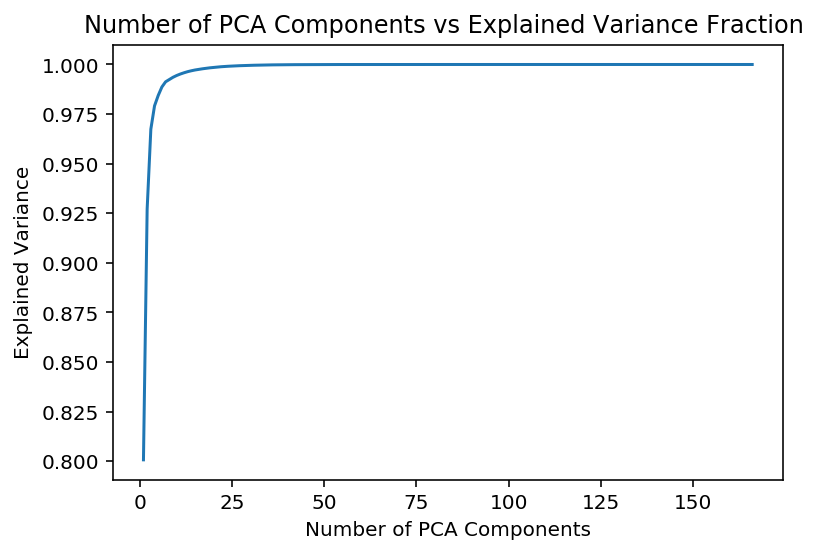

{'C': 0.004832930238571752, 'gamma': 0.001, 'kernel': 'linear'}
SVM with hyperparameter, PCA and SMOTE tuning
CV Scores:  [0.99111111 0.98666667 0.99111111 1.         0.99555556]
CV Average and standard deviation:  0.9928888888888888 +/- 0.004532461789860234


In [20]:
print("Before oversampling: ",Counter(y_train_w.values.ravel()))

#Drop any ensemble types with counts below 6
counts = y_train_w['ensemble'].value_counts()
X_train_w_smote = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w_smote = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]

#Now print data shape
print(X_train_w_smote.shape, y_train_w_smote.shape)

# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_w_smote, y_train_w_smote.values.ravel())

# summarize class distribution
print("After oversampling: ",Counter(y_SMOTE))

# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_w_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 166 i.e. one less than 167
all_possible_k = np.arange(1,167)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_w_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    

plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_SMOTE)
train_pca_w_smote = pca.transform(X_SMOTE)


from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w_smote, y_SMOTE)

print(grid.best_params_)

#Create SVM model with best hyperparameters, PCA and SMOTE

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter, PCA and SMOTE tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### 5.1.5 Hyperparameter tuning, PCA, SMOTE, Min Max Scaler

In [21]:
#### MinMaxScaler Application

#Create SVM model with best hyperparameters, PCA and SMOTE and MinMaxScaler

svm = make_pipeline(MinMaxScaler() ,SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and MinMax Scaler')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

SVM with hyperparameter tuning and MinMax Scaler
CV Scores:  [0.66222222 0.67555556 0.69333333 0.76       0.66222222]
CV Average and standard deviation:  0.6906666666666668 +/- 0.03649860474248498


#### 5.1.6 Hyperparameter tuning, PCA, SMOTE, Standard Scaler

In [22]:
#### Standard Scaler Application

#Create SVM model with best hyperparameters, PCA and SMOTE and StandardScaler

svm = make_pipeline(StandardScaler() ,SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and Standard Scaler')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

SVM with hyperparameter tuning and Standard Scaler
CV Scores:  [0.90222222 0.91555556 0.91555556 0.92888889 0.88444444]
CV Average and standard deviation:  0.9093333333333333 +/- 0.015032475133589107


### 5.2 MIDI Data Only

#### 5.2.1 Baseline model

In [23]:
#Create baseline SVM model with MIDI Data only

svm = make_pipeline(SVC())
svm.fit(X_train_m, y_train_m.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_m, y=y_train_m.values.ravel(), cv=5,n_jobs=1)
print('SVM Baseline with no hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

SVM Baseline with no hyperparameter tuning
CV Scores:  [0.62264151 0.66037736 0.66037736 0.65384615 0.67307692]
CV Average and standard deviation:  0.6540638606676342 +/- 0.016903423351571186


#### 5.2.2 Hyperparameter tuning

#### This model with C = 545 could not complete running after 2 hours. This is possibly because of the features makes the calculation complex.

In [ ]:
#Find best hyperparameters
param_grid = {'C': np.logspace(-4, 4, 20)}
grid = GridSearchCV(SVC(), param_grid)
  
# fitting the model for grid search
grid.fit(X_train_m, y_train_m.values.ravel())

print(grid.best_params_)

#Create Model with best hyperparameters

svm = make_pipeline(SVC(kernel='linear', C = 545.559 ))
svm.fit(X_train_m, y_train_m.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_m, y=y_train_m.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# The cell above could not run. Team to try running in cloud or delete cell

#### 5.2.3 SMOTE, PCA

In [ ]:
print("Before oversampling: ",Counter(y_train_m.values.ravel()))

#Drop any ensemble types with counts below 6
counts = y_train_m['ensemble'].value_counts()
X_train_m_smote = X_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
y_train_m_smote = y_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]

#Now print data shape
print(X_train_m_smote.shape, y_train_m_smote.shape)


# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_m_smote, y_train_m_smote.values.ravel())

# summarize class distribution
print("After oversampling: ",Counter(y_SMOTE))

# Create list of K dimensions to test for PCA
p_comp = np.arange(1,10)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_m_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 9 i.e. one less than 10
all_possible_k = np.arange(1,10)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_m_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    

plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

#Perform PCA with 2 components
pca=PCA(n_components = 2)
pca.fit(X_SMOTE)
train_pca_m_smote = pca.transform(X_SMOTE)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20)} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_m_smote, y_SMOTE)

print(grid.best_params_)

#Create SVM model with best hyperparameters and SMOTE

svm = make_pipeline(SVC(kernel='linear', C = grid.best_params_['C'] ))
svm.fit(train_pca_m_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter and SMOTE tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### MinMaxScaler Application

#Create SVM model with best hyperparameters,SMOTE and MinMaxScaler

svm = make_pipeline(MinMaxScaler() ,SVC(kernel='linear', C = grid.best_params_['C'] ))
svm.fit(train_pca_m_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and MinMaxScaler')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### StandardScaler Application

#Create SVM model with best hyperparameters,  SMOTE and StandardScaler

svm = make_pipeline(MinMaxScaler() ,SVC(kernel='linear', C = grid.best_params_['C']))
svm.fit(train_pca_m_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and StandardScaler')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# The cell above could not run. Team to try running in cloud or delete cell

#### Models on MIDI Data could not be run due to long runtime (4 hours) for linear, rbf and polynomial kernels.

#### One clue we have here on why the SVM model struggles with classifying the MIDI data is that the best C value is extremely high at 10,000. In other words, very low regularization strength and extreme overfitting is required to fit the model well

### 5.3 Combined Data (WAV & MIDI)

#### 5.3.1 Baseline model

In [24]:
#Create baseline SVM model with Spectral Wav and MIDI Data

svm = make_pipeline(SVC())
svm.fit(X_train_c, y_train_c.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_c, y=y_train_c.values.ravel(), cv=5,n_jobs=1)
print('SVM Baseline with no hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

SVM Baseline with no hyperparameter tuning
CV Scores:  [0.62264151 0.64150943 0.66037736 0.65384615 0.67307692]
CV Average and standard deviation:  0.6502902757619738 +/- 0.017176625192111616


#### 5.3.2 Hyperparameter tuning

In [ ]:
#Find best hyperparameters
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),                     
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid, cv=5)
  
# fitting the model for grid search
grid.fit(X_train_c, y_train_c.values.ravel())

print(grid.best_params_)


#Create Model with best hyperparameters

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(X_train_c, y_train_c.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_c, y=y_train_c.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

# The cell above could not run. Team to try running in cloud or delete cell

#### 5.3.2 Hyperparameter tuning, PCA

In [ ]:
# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 175 i.e. one less than 176
all_possible_k = np.arange(1,176)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    


plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()


#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_train_c)
train_pca_c = pca.transform(X_train_c)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_c, y_train_c.values.ravel())

print(grid.best_params_)

#Create Model with best hyperparameters and PCA
svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_c, y_train_c.values.ravel())


#Apply 5 fold cross validation scoring to make sure results are reliable
scores = cross_val_score(estimator = svm, X=train_pca_c, y=y_train_c.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning and PCA')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### Note the models could not complete the run when midi features were added.

# The cell above could not run. Team to try running in cloud or delete cell

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]

## 6. Neural Network

### 6.1 Spectral (WAV) Data Only

#### 6.1.1 Baseline model

Epoch 1/200
9/9 [==============================] - 0s 1ms/step - loss: 7.5979 - accuracy: 0.1027
Epoch 2/200
9/9 [==============================] - 0s 2ms/step - loss: 2.3974 - accuracy: 0.3384
Epoch 3/200
9/9 [==============================] - 0s 2ms/step - loss: 2.0085 - accuracy: 0.4715
Epoch 4/200
9/9 [==============================] - 0s 2ms/step - loss: 1.7366 - accuracy: 0.5171
Epoch 5/200
9/9 [==============================] - 0s 2ms/step - loss: 1.5821 - accuracy: 0.5323
Epoch 6/200
9/9 [==============================] - 0s 1ms/step - loss: 1.3980 - accuracy: 0.6426
Epoch 7/200
9/9 [==============================] - 0s 2ms/step - loss: 1.2582 - accuracy: 0.6540
Epoch 8/200
9/9 [==============================] - 0s 2ms/step - loss: 1.1296 - accuracy: 0.7148
Epoch 9/200
9/9 [==============================] - 0s 1ms/step - loss: 1.0052 - accuracy: 0.7262
Epoch 10/200
9/9 [==============================] - 0s 2ms/step - loss: 0.9608 - accuracy: 0.7072
Epoch 11/200
9/9 [===========

9/9 [==============================] - 0s 2ms/step - loss: 0.0093 - accuracy: 0.9962
Epoch 85/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 86/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0059 - accuracy: 1.0000
Epoch 87/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 88/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 89/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 90/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 91/200
9/9 [==============================] - 0s 2ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 92/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 93/200
9/9 [==============================] - 0s 3ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 94/200
9/9 [===============

9/9 [==============================] - 0s 2ms/step - loss: 7.2932e-04 - accuracy: 1.0000
Epoch 166/200
9/9 [==============================] - 0s 2ms/step - loss: 6.8751e-04 - accuracy: 1.0000
Epoch 167/200
9/9 [==============================] - 0s 2ms/step - loss: 6.7811e-04 - accuracy: 1.0000
Epoch 168/200
9/9 [==============================] - 0s 2ms/step - loss: 6.9006e-04 - accuracy: 1.0000
Epoch 169/200
9/9 [==============================] - 0s 2ms/step - loss: 6.6699e-04 - accuracy: 1.0000
Epoch 170/200
9/9 [==============================] - 0s 2ms/step - loss: 6.6764e-04 - accuracy: 1.0000
Epoch 171/200
9/9 [==============================] - 0s 3ms/step - loss: 6.4999e-04 - accuracy: 1.0000
Epoch 172/200
9/9 [==============================] - 0s 2ms/step - loss: 6.1258e-04 - accuracy: 1.0000
Epoch 173/200
9/9 [==============================] - 0s 2ms/step - loss: 6.6306e-04 - accuracy: 1.0000
Epoch 174/200
9/9 [==============================] - 0s 2ms/step - loss: 5.9774e-04 - a

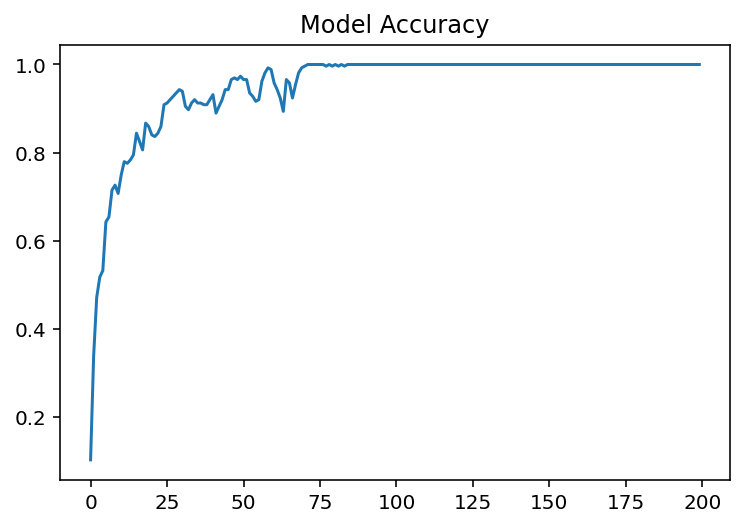

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(X_train_w, y_train_w, epochs=200)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
pass

#### observation: only using the wave features has the strongest performance in a neral network

### 6.2 MIDI Data Only

#### 6.2.1 Baseline model

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train_m, y_train_m, epochs=200)

Epoch 1/200
9/9 [==============================] - 1s 2ms/step - loss: 4547.1816 - accuracy: 0.0380 
Epoch 2/200
9/9 [==============================] - 0s 3ms/step - loss: 521.8198 - accuracy: 0.5932
Epoch 3/200
9/9 [==============================] - 0s 2ms/step - loss: 209.2014 - accuracy: 0.4905
Epoch 4/200
9/9 [==============================] - 0s 3ms/step - loss: 166.9907 - accuracy: 0.5779
Epoch 5/200
9/9 [==============================] - 0s 3ms/step - loss: 112.4240 - accuracy: 0.5361
Epoch 6/200
9/9 [==============================] - 0s 3ms/step - loss: 103.9966 - accuracy: 0.6046
Epoch 7/200
9/9 [==============================] - 0s 3ms/step - loss: 92.0713 - accuracy: 0.5932
Epoch 8/200
9/9 [==============================] - 0s 2ms/step - loss: 88.0719 - accuracy: 0.4715
Epoch 9/200
9/9 [==============================] - 0s 2ms/step - loss: 128.7430 - accuracy: 0.5741
Epoch 10/200
9/9 [==============================] - 0s 2ms/step - loss: 112.9054 - accuracy: 0.5665
Epoch 11/

9/9 [==============================] - 0s 3ms/step - loss: 17.4132 - accuracy: 0.6426
Epoch 84/200
9/9 [==============================] - 0s 4ms/step - loss: 11.7735 - accuracy: 0.6578
Epoch 85/200
9/9 [==============================] - 0s 3ms/step - loss: 15.0016 - accuracy: 0.5741
Epoch 86/200
9/9 [==============================] - 0s 3ms/step - loss: 12.1534 - accuracy: 0.7148
Epoch 87/200
9/9 [==============================] - 0s 3ms/step - loss: 12.7053 - accuracy: 0.6388
Epoch 88/200
9/9 [==============================] - 0s 3ms/step - loss: 13.0350 - accuracy: 0.6502
Epoch 89/200
9/9 [==============================] - 0s 2ms/step - loss: 20.6966 - accuracy: 0.6122
Epoch 90/200
9/9 [==============================] - 0s 3ms/step - loss: 21.1645 - accuracy: 0.5741
Epoch 91/200
9/9 [==============================] - 0s 3ms/step - loss: 23.8118 - accuracy: 0.6806
Epoch 92/200
9/9 [==============================] - 0s 3ms/step - loss: 24.1615 - accuracy: 0.5665
Epoch 93/200
9/9 [=====

9/9 [==============================] - 0s 3ms/step - loss: 1.1834 - accuracy: 0.6768
Epoch 165/200
9/9 [==============================] - 0s 3ms/step - loss: 1.1865 - accuracy: 0.7490
Epoch 166/200
9/9 [==============================] - 0s 3ms/step - loss: 1.2851 - accuracy: 0.6692
Epoch 167/200
9/9 [==============================] - 0s 3ms/step - loss: 1.4770 - accuracy: 0.7414
Epoch 168/200
9/9 [==============================] - 0s 3ms/step - loss: 1.7061 - accuracy: 0.6806
Epoch 169/200
9/9 [==============================] - 0s 3ms/step - loss: 1.5623 - accuracy: 0.6996
Epoch 170/200
9/9 [==============================] - 0s 3ms/step - loss: 1.7359 - accuracy: 0.6844
Epoch 171/200
9/9 [==============================] - 0s 3ms/step - loss: 1.9925 - accuracy: 0.6540
Epoch 172/200
9/9 [==============================] - 0s 3ms/step - loss: 1.4122 - accuracy: 0.7224
Epoch 173/200
9/9 [==============================] - 0s 3ms/step - loss: 1.6655 - accuracy: 0.7034
Epoch 174/200
9/9 [=====

### 6.3 Combined Data (WAV & MIDI)

#### 6.3.1 Baseline model

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(176, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dense(21)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train_c, y_train_c, epochs=200)

Epoch 1/200
9/9 [==============================] - 0s 2ms/step - loss: 2802.7139 - accuracy: 0.3042
Epoch 2/200
9/9 [==============================] - 0s 2ms/step - loss: 561.3738 - accuracy: 0.5323
Epoch 3/200
9/9 [==============================] - 0s 2ms/step - loss: 351.1660 - accuracy: 0.5209
Epoch 4/200
9/9 [==============================] - 0s 2ms/step - loss: 247.9181 - accuracy: 0.5817
Epoch 5/200
9/9 [==============================] - 0s 2ms/step - loss: 164.0799 - accuracy: 0.6578
Epoch 6/200
9/9 [==============================] - 0s 2ms/step - loss: 110.4107 - accuracy: 0.5817
Epoch 7/200
9/9 [==============================] - 0s 2ms/step - loss: 85.2178 - accuracy: 0.5894
Epoch 8/200
9/9 [==============================] - 0s 2ms/step - loss: 99.5163 - accuracy: 0.6046
Epoch 9/200
9/9 [==============================] - 0s 2ms/step - loss: 97.9811 - accuracy: 0.5551
Epoch 10/200
9/9 [==============================] - 0s 2ms/step - loss: 99.3970 - accuracy: 0.5856
Epoch 11/200

9/9 [==============================] - 0s 3ms/step - loss: 4.4171 - accuracy: 0.7072
Epoch 84/200
9/9 [==============================] - 0s 3ms/step - loss: 9.4892 - accuracy: 0.6844
Epoch 85/200
9/9 [==============================] - 0s 2ms/step - loss: 10.0384 - accuracy: 0.6502
Epoch 86/200
9/9 [==============================] - 0s 3ms/step - loss: 13.3616 - accuracy: 0.5932
Epoch 87/200
9/9 [==============================] - 0s 2ms/step - loss: 21.3440 - accuracy: 0.5665
Epoch 88/200
9/9 [==============================] - 0s 3ms/step - loss: 23.0960 - accuracy: 0.7072
Epoch 89/200
9/9 [==============================] - 0s 3ms/step - loss: 21.1597 - accuracy: 0.5589
Epoch 90/200
9/9 [==============================] - 0s 3ms/step - loss: 22.3649 - accuracy: 0.6198
Epoch 91/200
9/9 [==============================] - 0s 2ms/step - loss: 16.4016 - accuracy: 0.6806
Epoch 92/200
9/9 [==============================] - 0s 2ms/step - loss: 11.3219 - accuracy: 0.6692
Epoch 93/200
9/9 [=======

Epoch 166/200
9/9 [==============================] - 0s 2ms/step - loss: 1.7640 - accuracy: 0.7529
Epoch 167/200
9/9 [==============================] - 0s 2ms/step - loss: 1.4236 - accuracy: 0.7833
Epoch 168/200
9/9 [==============================] - 0s 2ms/step - loss: 1.7360 - accuracy: 0.6654
Epoch 169/200
9/9 [==============================] - 0s 2ms/step - loss: 1.6167 - accuracy: 0.7072
Epoch 170/200
9/9 [==============================] - 0s 2ms/step - loss: 2.8445 - accuracy: 0.6730
Epoch 171/200
9/9 [==============================] - 0s 2ms/step - loss: 4.2144 - accuracy: 0.5627
Epoch 172/200
9/9 [==============================] - 0s 2ms/step - loss: 5.3961 - accuracy: 0.7110
Epoch 173/200
9/9 [==============================] - 0s 2ms/step - loss: 5.4270 - accuracy: 0.6502
Epoch 174/200
9/9 [==============================] - 0s 2ms/step - loss: 3.3336 - accuracy: 0.6844
Epoch 175/200
9/9 [==============================] - 0s 2ms/step - loss: 2.9289 - accuracy: 0.7072
Epoch 176/

### Observation : Cases removed through SMOTE run on the training data will not be classified correctly in the test data.

# Conclusion to be added 

# SVM Conclusion :

- The MIDI data and Data Set containing MIDI data could not complete running on the SVM model.

- One clue we have here on why the SVM model struggles with classifying the MIDI data is that the best C value is extremely high at 10,000. In other words, very low regularization strength and extreme overfitting is required to fit the model well.

- In conclusion, the best SVM model was run on spectral data and has a 5-fold cross-validation score of 99.47% with standard deviation of 0.00653 when a cross validation was done on training data,

- It has PCA with 15 components, SMOTE application to balance the sample classes and also hyperparameter tuning where we found the best C, best gamma and also that linear kernel is the best kernel to use amongst the 3 types that are available.

- When run on test data, the best SVM model had an F1 Score of 84.17%.


In [ ]:
### Best SVM Model using Spectral Data

In [ ]:
#Drop any ensemble types with counts below 6
counts = y_train_w['ensemble'].value_counts()
X_train_w_smote = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w_smote = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]

# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_w_smote, y_train_w_smote.values.ravel())

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_SMOTE)
train_pca_w_smote = pca.transform(X_SMOTE)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w_smote, y_SMOTE)

print(grid.best_params_)

#Create SVM model with best hyperparameters, PCA and SMOTE

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

test_pca_w = pca.transform(X_test_w)
predictions_pca_w = svm.predict(test_pca_w)
print('Accuracy score: ', accuracy_score(predictions_pca_w, np.array(y_test_w)))
print('F1 Score: ', f1_score(predictions_pca_w, np.array(y_test_w), average='weighted'))
print('Classification report: \n', classification_report(np.array(y_test_w), predictions_pca_w))
print('Confusion Matrix: \n', confusion_matrix(np.array(y_test_w), predictions_pca_w))